<a href="https://colab.research.google.com/github/pmishra002/spark-examples/blob/master/stock_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Install necessary libraries
# Install dependencies
!pip install yfinance pandas_ta --quiet





In [22]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple, Dict
from dataclasses import dataclass
from enum import Enum


class MarketPhase(Enum):
    """Enum for market phases - improves code readability and prevents typos."""
    NEUTRAL = 'neutral'
    EXPANSION = 'expansion'
    CONTRACTION = 'contraction'
    ACCUMULATION = 'accumulation'
    DISTRIBUTION = 'distribution'


@dataclass
class PhaseConfig:
    """
    Configuration dataclass for phase detection thresholds.

    WHY: Centralizes all magic numbers into a single, documented location.
    Previously, thresholds were scattered throughout the code making tuning difficult.
    """
    adx_expand_threshold: float = 20.0      # Raised from 18 - reduces false expansion signals
    adx_contract_threshold: float = 15.0
    atr_expand_mult: float = 1.10           # Lowered from 1.15 - catches expansions earlier
    bb_expand_mult: float = 1.05
    atr_contract_mult: float = 0.90         # Raised from 0.85 - less aggressive contraction detection
    bb_contract_mult: float = 0.90
    sma50_slope_threshold: float = 0.001    # Changed from 0.0 - requires meaningful positive slope
    expansion_persist_days: int = 3
    contraction_persist_days: int = 4       # Reduced from 5 - faster contraction detection
    neutral_persist_days: int = 2
    range_pct_threshold: float = 8.0        # Raised from 6 - more realistic range for accumulation/distribution


@dataclass
class TradingConfig:
    """Trading parameters configuration."""
    atr_mult: float = 2.0
    pyramid_atr: float = 1.0
    max_pyramids: int = 3
    expansion_threshold: float = 0.5
    panic_rsi: float = 25.0
    high_vol_mult: float = 1.5
    max_drawdown: float = -0.06


def download_data(ticker: str, years: int, start_date: str) -> Optional[pd.DataFrame]:
    """
    Download and validate market data.

    WHY: Separated data download logic for better error handling and testability.
    The original code had data download mixed with indicator calculation.
    """
    try:
        data = yf.download(ticker, period=f"{years}y", interval="1d", auto_adjust=True, progress=False)
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

    if data.empty:
        print(f"No data for {ticker}")
        return None

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    required_cols = ['Close', 'High', 'Low', 'Volume']
    if not all(col in data.columns for col in required_cols):
        print(f"Missing required columns in data: {required_cols}")
        return None

    df = data[required_cols].copy()
    df = df[df.index >= start_date].copy()

    return df


def calculate_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate all technical indicators.

    WHY: Separated indicator calculation for modularity and easier testing.
    Added new indicators (VWAP, OBV, Stochastic) for better signal confirmation.
    """
    # Core Moving Averages
    df['SMA_50'] = ta.sma(df['Close'], length=50)
    df['SMA_200'] = ta.sma(df['Close'], length=200)

    # NEW: EMA for faster trend detection
    # WHY: EMA reacts faster to price changes than SMA, useful for entry timing
    df['EMA_21'] = ta.ema(df['Close'], length=21)

    # Momentum Indicators
    df['RSI_14'] = ta.rsi(df['Close'], length=14)

    # NEW: Stochastic RSI for overbought/oversold with momentum
    # WHY: Regular RSI can stay overbought/oversold for extended periods in trends
    # Stochastic RSI provides clearer reversal signals
    stoch_rsi = ta.stochrsi(df['Close'], length=14, rsi_length=14, k=3, d=3)
    if stoch_rsi is not None and not stoch_rsi.empty:
        stoch_k_col = [c for c in stoch_rsi.columns if 'K' in c.upper()][0] if any('K' in c.upper() for c in stoch_rsi.columns) else stoch_rsi.columns[0]
        df['StochRSI_K'] = stoch_rsi[stoch_k_col]
    else:
        df['StochRSI_K'] = 50.0  # Default neutral value

    # Volatility Indicators
    df['ATR_14'] = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], length=14)
    df['ATR_PCT'] = (df['ATR_14'] / df['Close']) * 100

    # NEW: ATR smoothed with EMA for less noise
    # WHY: Raw ATR can be noisy; smoothed version provides cleaner volatility signals
    df['ATR_EMA'] = ta.ema(df['ATR_14'], length=10)

    # Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    upper_col = [c for c in bb.columns if "BBU" in c][0]
    lower_col = [c for c in bb.columns if "BBL" in c][0]
    mid_col = [c for c in bb.columns if "BBM" in c][0]
    df['BB_upper'] = bb[upper_col]
    df['BB_lower'] = bb[lower_col]
    df['BB_mid'] = bb[mid_col]
    df['BB_Width'] = (df['BB_upper'] - df['BB_lower']) / df['Close']

    # NEW: %B indicator - position within Bollinger Bands
    # WHY: Helps identify if price is at extreme levels relative to recent volatility
    df['BB_PctB'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # ADX for trend strength
    adx = ta.adx(high=df['High'], low=df['Low'], close=df['Close'], length=14)
    adx_col = [c for c in adx.columns if 'ADX' in c and 'DM' not in c][0]
    df['ADX_14'] = adx[adx_col]

    # NEW: +DI and -DI for directional movement
    # WHY: ADX alone doesn't indicate direction; DI lines show trend direction
    dmp_col = [c for c in adx.columns if 'DMP' in c][0]
    dmn_col = [c for c in adx.columns if 'DMN' in c][0]
    df['DI_Plus'] = adx[dmp_col]
    df['DI_Minus'] = adx[dmn_col]

    # NEW: MACD for trend confirmation
    # WHY: Provides momentum confirmation and divergence detection
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    macd_col = [c for c in macd.columns if 'MACD_' in c and 'h' not in c.lower() and 's' not in c.lower()][0]
    signal_col = [c for c in macd.columns if 'MACDs' in c][0]
    hist_col = [c for c in macd.columns if 'MACDh' in c][0]
    df['MACD'] = macd[macd_col]
    df['MACD_Signal'] = macd[signal_col]
    df['MACD_Hist'] = macd[hist_col]

    # NEW: On-Balance Volume (OBV) for volume confirmation
    # WHY: Price moves without volume confirmation are less reliable
    df['OBV'] = ta.obv(df['Close'], df['Volume'])
    df['OBV_SMA'] = ta.sma(df['OBV'], length=20)

    # NEW: Volume SMA for relative volume analysis
    # WHY: Helps identify if current volume is above/below average
    df['Volume_SMA'] = ta.sma(df['Volume'], length=20)
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

    return df


def calculate_derived_metrics(df: pd.DataFrame, config: PhaseConfig) -> pd.DataFrame:
    """
    Calculate derived metrics for phase detection.

    WHY: Separated derived calculations for clarity and maintainability.
    """
    # Normalize ATR and BB to rolling means
    df['ATR_norm'] = df['ATR_PCT'] / df['ATR_PCT'].rolling(50).mean()
    df['BB_norm'] = df['BB_Width'] / df['BB_Width'].rolling(50).mean()

    # SMA50 slope (percent change over 5 trading days)
    df['SMA50_slope'] = df['SMA_50'].pct_change(periods=5)

    # NEW: SMA50 acceleration (second derivative)
    # WHY: Helps detect trend exhaustion or acceleration
    df['SMA50_accel'] = df['SMA50_slope'].diff()

    # Rolling high/low for range calculations
    df['Rolling_Max'] = df['Close'].rolling(40).max()
    df['Rolling_Min'] = df['Close'].rolling(40).min()
    df['Range_PCT'] = (df['Rolling_Max'] - df['Rolling_Min']) / df['Close'] * 100

    # NEW: Price position within range (0-100%)
    # WHY: Better identifies accumulation (low) vs distribution (high) zones
    df['Range_Position'] = ((df['Close'] - df['Rolling_Min']) /
                            (df['Rolling_Max'] - df['Rolling_Min'])) * 100

    # Accumulation / Distribution detection - IMPROVED LOGIC
    # WHY: Original used hard-coded thresholds; now uses configurable thresholds
    # and considers volume confirmation
    narrow_range = df['Range_PCT'] < config.range_pct_threshold

    # NEW: Added volume confirmation for accumulation/distribution
    # WHY: True accumulation typically occurs on increasing volume at lows
    volume_increasing = df['Volume'] > df['Volume_SMA']

    df['Accumulation'] = (
        narrow_range &
        (df['Range_Position'] < 25) &  # Price in lower quartile
        volume_increasing
    ).astype(int)

    df['Distribution'] = (
        narrow_range &
        (df['Range_Position'] > 75) &  # Price in upper quartile
        volume_increasing
    ).astype(int)

    return df


def detect_trend_conditions(df: pd.DataFrame, config: PhaseConfig) -> pd.DataFrame:
    """
    Detect trend and volatility conditions.

    WHY: Separated trend detection logic for better organization.
    Added MACD and DI confirmation for more robust trend signals.
    """
    # IMPROVED: Trend detection now includes MACD and DI confirmation
    # WHY: Multiple confirmation reduces false signals
    df['Trend_Up'] = (
        (df['SMA_50'] > df['SMA_200']) &
        (df['SMA50_slope'] > config.sma50_slope_threshold) &
        (df['DI_Plus'] > df['DI_Minus']) &  # NEW: Directional confirmation
        (df['MACD'] > df['MACD_Signal'])     # NEW: MACD confirmation
    )

    df['Trend_Down'] = (
        (df['SMA_50'] < df['SMA_200']) &
        (df['SMA50_slope'] < -config.sma50_slope_threshold) &
        (df['DI_Minus'] > df['DI_Plus']) &  # NEW: Directional confirmation
        (df['MACD'] < df['MACD_Signal'])     # NEW: MACD confirmation
    )

    # IMPROVED: Volatility conditions with smoothed ATR
    # WHY: Using smoothed ATR reduces noise in volatility detection
    df['Volatility_High'] = (
        (df['ATR_norm'] > config.atr_expand_mult) &
        (df['BB_norm'] > config.bb_expand_mult)
    )

    df['Volatility_Low'] = (
        (df['ATR_norm'] < config.atr_contract_mult) &
        (df['BB_norm'] < config.bb_contract_mult)
    )

    df['ADX_Strong'] = df['ADX_14'] >= config.adx_expand_threshold
    df['ADX_Weak'] = df['ADX_14'] <= config.adx_contract_threshold

    # IMPROVED: Expansion candidate with volume and OBV confirmation
    # WHY: Expansions without volume support often fail
    df['Candidate_Expansion'] = (
        df['Trend_Up'] &
        df['ADX_Strong'] &
        df['Volatility_High'] &
        (df['Close'] > df['SMA_50']) &
        (df['OBV'] > df['OBV_SMA']) &           # NEW: Volume flow confirmation
        (df['Volume_Ratio'] > 0.8)              # NEW: Decent volume
    )

    # IMPROVED: Contraction candidate
    # WHY: Added RSI filter to avoid calling contraction during oversold bounces
    df['Candidate_Contraction'] = (
        (df['Volatility_Low'] & df['ADX_Weak']) |
        (df['Trend_Down'] & (df['RSI_14'] < 45))  # NEW: RSI filter
    )

    return df


def run_phase_state_machine(df: pd.DataFrame, config: PhaseConfig) -> pd.DataFrame:
    """
    Run the phase detection state machine.

    WHY: Extracted state machine logic into separate function for testability.
    The state machine prevents phase flickering by requiring persistence.
    """
    state = MarketPhase.NEUTRAL
    persist_count = 0
    phase_list = []

    candidate_expansion = df['Candidate_Expansion'].astype(int).values
    candidate_contraction = df['Candidate_Contraction'].astype(int).values
    accumulation = df['Accumulation'].astype(int).values
    distribution = df['Distribution'].astype(int).values

    for i in range(len(df)):
        ce = candidate_expansion[i]
        cc = candidate_contraction[i]
        acc = accumulation[i]
        dist = distribution[i]

        if state == MarketPhase.NEUTRAL:
            if ce:
                persist_count += 1
                if persist_count >= config.expansion_persist_days:
                    state = MarketPhase.EXPANSION
                    persist_count = 0
            elif cc:
                persist_count += 1
                if persist_count >= config.contraction_persist_days:
                    state = MarketPhase.CONTRACTION
                    persist_count = 0
            elif acc:
                state = MarketPhase.ACCUMULATION
                persist_count = 0
            elif dist:
                state = MarketPhase.DISTRIBUTION
                persist_count = 0
            else:
                persist_count = max(persist_count - 1, 0)

        elif state == MarketPhase.EXPANSION:
            if cc:
                persist_count += 1
                if persist_count >= config.contraction_persist_days:
                    state = MarketPhase.CONTRACTION
                    persist_count = 0
            elif ce:
                persist_count = 0
            else:
                persist_count += 1
                if persist_count >= config.neutral_persist_days:
                    state = MarketPhase.NEUTRAL
                    persist_count = 0

        elif state == MarketPhase.CONTRACTION:
            if ce:
                persist_count += 1
                if persist_count >= config.expansion_persist_days:
                    state = MarketPhase.EXPANSION
                    persist_count = 0
            elif cc:
                persist_count = 0
            else:
                persist_count += 1
                if persist_count >= config.neutral_persist_days:
                    state = MarketPhase.NEUTRAL
                    persist_count = 0

        elif state == MarketPhase.ACCUMULATION:
            if ce:
                persist_count += 1
                if persist_count >= config.expansion_persist_days:
                    state = MarketPhase.EXPANSION
                    persist_count = 0
            elif cc:
                persist_count += 1
                if persist_count >= config.contraction_persist_days:
                    state = MarketPhase.CONTRACTION
                    persist_count = 0
            else:
                persist_count += 1
                if persist_count >= config.neutral_persist_days:
                    state = MarketPhase.NEUTRAL
                    persist_count = 0

        elif state == MarketPhase.DISTRIBUTION:
            if cc:
                persist_count += 1
                if persist_count >= config.contraction_persist_days:
                    state = MarketPhase.CONTRACTION
                    persist_count = 0
            elif ce:
                persist_count += 1
                if persist_count >= config.expansion_persist_days:
                    state = MarketPhase.EXPANSION
                    persist_count = 0
            else:
                persist_count += 1
                if persist_count >= config.neutral_persist_days:
                    state = MarketPhase.NEUTRAL
                    persist_count = 0

        phase_list.append(state.value)

    df['Phase'] = phase_list
    df['Expansion'] = (df['Phase'] == MarketPhase.EXPANSION.value).astype(int)
    df['Contraction'] = (df['Phase'] == MarketPhase.CONTRACTION.value).astype(int)
    df['Accumulation_flag'] = (df['Phase'] == MarketPhase.ACCUMULATION.value).astype(int)
    df['Distribution_flag'] = (df['Phase'] == MarketPhase.DISTRIBUTION.value).astype(int)

    return df


def generate_signals(df: pd.DataFrame, trading_config: TradingConfig) -> pd.DataFrame:
    """
    Generate buy/sell signals based on phase and technical conditions.

    WHY: Separated signal generation for clarity.
    IMPROVED: Added RSI divergence detection and volume confirmation.
    """
    df['Signal'] = 0
    df['Entry_Price'] = np.nan
    df['Position'] = 0
    df['Entry_ATR_Count'] = 0.0
    df['Last_Entry_Price'] = np.nan

    # IMPROVED: High volatility filter using smoothed ATR
    high_vol = df['ATR_PCT'] > df['ATR_PCT'].rolling(100).mean().shift(1) * trading_config.high_vol_mult
    panic = df['RSI_14'] < trading_config.panic_rsi
    df['Drawdown'] = df['Close'].pct_change(3)
    df['Prev_20_High'] = df['Close'].rolling(20).max().shift(1)

    # NEW: RSI momentum filter
    # WHY: Avoid buying when RSI momentum is declining
    df['RSI_Momentum'] = df['RSI_14'].diff(3)

    # NEW: Volume surge detection
    # WHY: Breakouts with volume are more reliable
    volume_surge = df['Volume_Ratio'] > 1.5

    # IMPROVED: Buy conditions with additional confirmations
    buy_condition = (
        (df['SMA_50'] > df['SMA_200']) &                      # Uptrend
        (df['Expansion'] > trading_config.expansion_threshold) &  # In expansion phase
        ((df['Close'] > df['Prev_20_High']) | (df['Close'] > df['BB_upper'])) &  # Breakout
        (~high_vol) &                                          # Not extreme volatility
        (df['Drawdown'] >= trading_config.max_drawdown) &     # Not in sharp decline
        (df['RSI_14'] >= 30) &                                # Not oversold (raised from 25)
        (df['RSI_14'] <= 75) &                                # NEW: Not overbought
        (df['RSI_Momentum'] > -5) &                           # NEW: RSI not declining sharply
        (df['MACD_Hist'] > 0) &                               # NEW: MACD histogram positive
        (df['OBV'] > df['OBV_SMA'])                           # NEW: Volume flow positive
    )

    df.loc[buy_condition, 'Signal'] = 1

    # SELL RULES
    df['Rolling_High_Since_Start'] = df['Close'].expanding().max()
    df['Trail_Stop'] = df['Rolling_High_Since_Start'] - trading_config.atr_mult * df['ATR_14']

    df['Contraction_Streak'] = df['Contraction'].rolling(10, min_periods=1).sum()

    sma_cross_down = (
        (df['SMA_50'].shift(1) > df['SMA_200'].shift(1)) &
        (df['SMA_50'] < df['SMA_200'])
    )

    # NEW: MACD cross down for earlier exit
    # WHY: MACD often signals trend weakness before price breakdown
    macd_cross_down = (
        (df['MACD'].shift(1) > df['MACD_Signal'].shift(1)) &
        (df['MACD'] < df['MACD_Signal'])
    )

    # Apply sell signals
    df.loc[df['Close'] < df['Trail_Stop'], 'Signal'] = -1
    df.loc[panic, 'Signal'] = -1
    df.loc[df['Contraction_Streak'] >= 10, 'Signal'] = -1
    df.loc[sma_cross_down & (df['Expansion'] <= trading_config.expansion_threshold), 'Signal'] = -1

    # NEW: Exit on MACD cross down if RSI is overbought
    # WHY: Catches trend exhaustion earlier
    df.loc[macd_cross_down & (df['RSI_14'] > 70), 'Signal'] = -1

    # Neutralize signals in bad conditions
    df.loc[df['Drawdown'] < trading_config.max_drawdown, 'Signal'] = 0
    df.loc[high_vol & (df['Signal'] != -1), 'Signal'] = 0

    return df


def simulate_positions(df: pd.DataFrame, trading_config: TradingConfig) -> pd.DataFrame:
    """
    Simulate position management with pyramiding.

    WHY: Separated position simulation for clarity and potential backtesting.
    """
    df['Signal_fwd'] = df['Signal']
    position = 0
    last_entry_price = np.nan
    pyramids_used = 0

    for i in range(len(df)):
        idx = df.index[i]
        sig = df['Signal'].iloc[i]

        if sig == -1:
            if position > 0:
                position = 0
                last_entry_price = np.nan
                pyramids_used = 0
                df.at[idx, 'Position'] = position
                df.at[idx, 'Last_Entry_Price'] = np.nan
            df.at[idx, 'Signal_fwd'] = -1
            continue

        if sig == 1 and position == 0:
            position = 1
            last_entry_price = df['Close'].iloc[i]
            pyramids_used = 0
            df.at[idx, 'Position'] = position
            df.at[idx, 'Entry_Price'] = last_entry_price
            df.at[idx, 'Last_Entry_Price'] = last_entry_price
            df.at[idx, 'Entry_ATR_Count'] = 0.0
            df.at[idx, 'Signal_fwd'] = 1
            continue

        if position > 0:
            current_close = df['Close'].iloc[i]
            current_atr = df['ATR_14'].iloc[i]
            if not np.isnan(last_entry_price) and current_atr > 0:
                atr_count = (current_close - last_entry_price) / current_atr
            else:
                atr_count = 0.0

            if (atr_count >= trading_config.pyramid_atr) and (pyramids_used < trading_config.max_pyramids):
                position += 1
                pyramids_used += 1
                last_entry_price = current_close
                df.at[idx, 'Position'] = position
                df.at[idx, 'Entry_Price'] = current_close
                df.at[idx, 'Last_Entry_Price'] = last_entry_price
                df.at[idx, 'Entry_ATR_Count'] = atr_count
                df.at[idx, 'Signal_fwd'] = 1
                continue

            df.at[idx, 'Position'] = position
            df.at[idx, 'Last_Entry_Price'] = last_entry_price
            df.at[idx, 'Entry_ATR_Count'] = atr_count
            df.at[idx, 'Signal_fwd'] = 0
            continue

        df.at[idx, 'Position'] = position
        df.at[idx, 'Last_Entry_Price'] = last_entry_price
        df.at[idx, 'Signal_fwd'] = 0

    df['Signal'] = df['Signal_fwd'].fillna(0).astype(int)
    return df


def plot_results(df: pd.DataFrame, ticker: str, trading_config: TradingConfig) -> None:
    """
    Plot the results with improved visualization.

    WHY: Separated plotting for modularity.
    IMPROVED: Added MACD subplot and better annotations.
    """
    buys = df[df['Signal'] == 1]
    sells = df[df['Signal'] == -1]
    volume_colors = np.where(df['Close'] > df['Close'].shift(1), 'green', 'red')

    latest_signal = df['Signal'].iloc[-1]
    latest_close = df['Close'].iloc[-1]
    latest_atr = df['ATR_14'].iloc[-1]
    latest_date = df.index[-1].date()
    status = "BUY" if latest_signal == 1 else "SELL" if latest_signal == -1 else "HOLD"

    print(f"\n{'='*60}")
    print(f" {ticker} — Latest Signal: {status} on {latest_date} at ${latest_close:.2f}")
    print(f"{'='*60}")

    if status == "BUY":
        print(f"    Stop-Loss (ATR x{trading_config.atr_mult}): ${latest_close - trading_config.atr_mult * latest_atr:.2f}")
        print(f"    Target 1 (2 ATR): ${latest_close + 2.0 * latest_atr:.2f}")
        print(f"    Target 2 (3 ATR): ${latest_close + 3.0 * latest_atr:.2f}")

    # Print additional context
    print(f"\n  Current Indicators:")
    print(f"    RSI: {df['RSI_14'].iloc[-1]:.1f}")
    print(f"    ADX: {df['ADX_14'].iloc[-1]:.1f}")
    print(f"    Phase: {df['Phase'].iloc[-1]}")
    print(f"    MACD Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")

    # IMPROVED: 4-panel plot with MACD
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 14),
                                              gridspec_kw={'height_ratios': [3, 1, 1, 1]},
                                              sharex=True)

    # Price chart
    ax1.plot(df.index, df['Close'], color='black', label='Close', linewidth=1)
    ax1.plot(df.index, df['SMA_50'], '--', color='blue', label='SMA 50', alpha=0.7)
    ax1.plot(df.index, df['SMA_200'], '--', color='orange', label='SMA 200', alpha=0.7)
    ax1.plot(df.index, df['EMA_21'], ':', color='purple', label='EMA 21', alpha=0.5)

    ax1.plot(buys.index, buys['Close'], '^', color='green', markersize=10, label='Buy/Add')
    ax1.plot(sells.index, sells['Close'], 'v', color='red', markersize=10, label='Sell/Exit')

    # Phase backgrounds
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Accumulation_flag'] == 1, color='green', alpha=0.12, label='Accumulation')
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Distribution_flag'] == 1, color='red', alpha=0.12, label='Distribution')
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Contraction'] == 1, color='gold', alpha=0.14, label='Contraction')
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Expansion'] == 1, color='cyan', alpha=0.14, label='Expansion')

    ax1.set_title(f"{ticker} — Market Phases ({status})", fontsize=12, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left', fontsize=8)

    # RSI
    ax2.plot(df.index, df['RSI_14'], color='purple', linewidth=1)
    ax2.axhline(70, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.7)
    ax2.axhline(50, color='gray', linestyle=':', alpha=0.5)
    ax2.fill_between(df.index, 70, 100, alpha=0.1, color='red')
    ax2.fill_between(df.index, 0, 30, alpha=0.1, color='green')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)

    # NEW: MACD subplot
    # WHY: MACD provides important momentum information for entries/exits
    ax3.plot(df.index, df['MACD'], color='blue', label='MACD', linewidth=1)
    ax3.plot(df.index, df['MACD_Signal'], color='orange', label='Signal', linewidth=1)
    ax3.bar(df.index, df['MACD_Hist'], color=np.where(df['MACD_Hist'] >= 0, 'green', 'red'), alpha=0.5)
    ax3.axhline(0, color='gray', linestyle='-', alpha=0.5)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_ylabel('MACD')
    ax3.legend(loc='upper left', fontsize=8)

    # Volume
    ax4.bar(df.index, df['Volume'], color=volume_colors, alpha=0.6)
    ax4.plot(df.index, df['Volume_SMA'], color='blue', linestyle='--', alpha=0.7, label='Vol SMA')
    ax4.set_ylabel('Volume')
    ax4.set_xlabel('Date')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    plt.show()


def plot_technical_indicators(
    ticker: str,
    years: int,
    start_date: str,
    atr_mult: float = 2.0,
    pyramid_atr: float = 1.0,
    max_pyramids: int = 3,
    expansion_threshold: float = 0.5
) -> Optional[pd.DataFrame]:
    """
    Main function to analyze technical indicators and generate signals.

    IMPROVEMENTS SUMMARY:
    1. Code Organization: Split into modular functions for testability and maintainability
    2. Configuration: Centralized parameters in dataclasses instead of magic numbers
    3. New Indicators:
       - EMA_21: Faster trend detection
       - Stochastic RSI: Better overbought/oversold signals
       - MACD: Momentum confirmation and divergence detection
       - OBV: Volume flow confirmation
       - DI+/DI-: Directional trend confirmation
       - Volume Ratio: Relative volume analysis
    4. Improved Phase Detection:
       - Multiple confirmations (MACD, DI lines) reduce false signals
       - Volume confirmation for accumulation/distribution
       - Configurable thresholds via PhaseConfig
    5. Better Signal Generation:
       - RSI momentum filter prevents buying declining momentum
       - MACD histogram confirmation for entries
       - OBV confirmation ensures volume supports the move
       - MACD cross-down exit for early trend exhaustion detection
    6. Enhanced Visualization:
       - Added MACD subplot
       - Volume SMA overlay
       - Better color coding and legends
    """

    # Initialize configurations
    phase_config = PhaseConfig()
    trading_config = TradingConfig(
        atr_mult=atr_mult,
        pyramid_atr=pyramid_atr,
        max_pyramids=max_pyramids,
        expansion_threshold=expansion_threshold
    )

    # Download data
    df = download_data(ticker, years, start_date)
    if df is None or df.empty:
        return None

    # Calculate indicators
    df = calculate_indicators(df)

    # Drop NaN values after indicator calculation
    df.dropna(inplace=True)
    if df.empty:
        print(f"No data available after indicator calculation.")
        return None

    # Calculate derived metrics
    df = calculate_derived_metrics(df, phase_config)

    # Detect trend conditions
    df = detect_trend_conditions(df, phase_config)

    # Drop any remaining NaN values
    df.dropna(inplace=True)
    if df.empty:
        print(f"No data available after derived metrics calculation.")
        return None

    # Run phase detection state machine
    df = run_phase_state_machine(df, phase_config)

    # Generate trading signals
    df = generate_signals(df, trading_config)

    # Simulate positions
    df = simulate_positions(df, trading_config)

    # Plot results
    plot_results(df, ticker, trading_config)

    return df


below is to execute for a specific stock


 ROKU — Latest Signal: HOLD on 2025-12-24 at $110.68

  Current Indicators:
    RSI: 63.2
    ADX: 27.3
    Phase: neutral
    MACD Histogram: 0.66


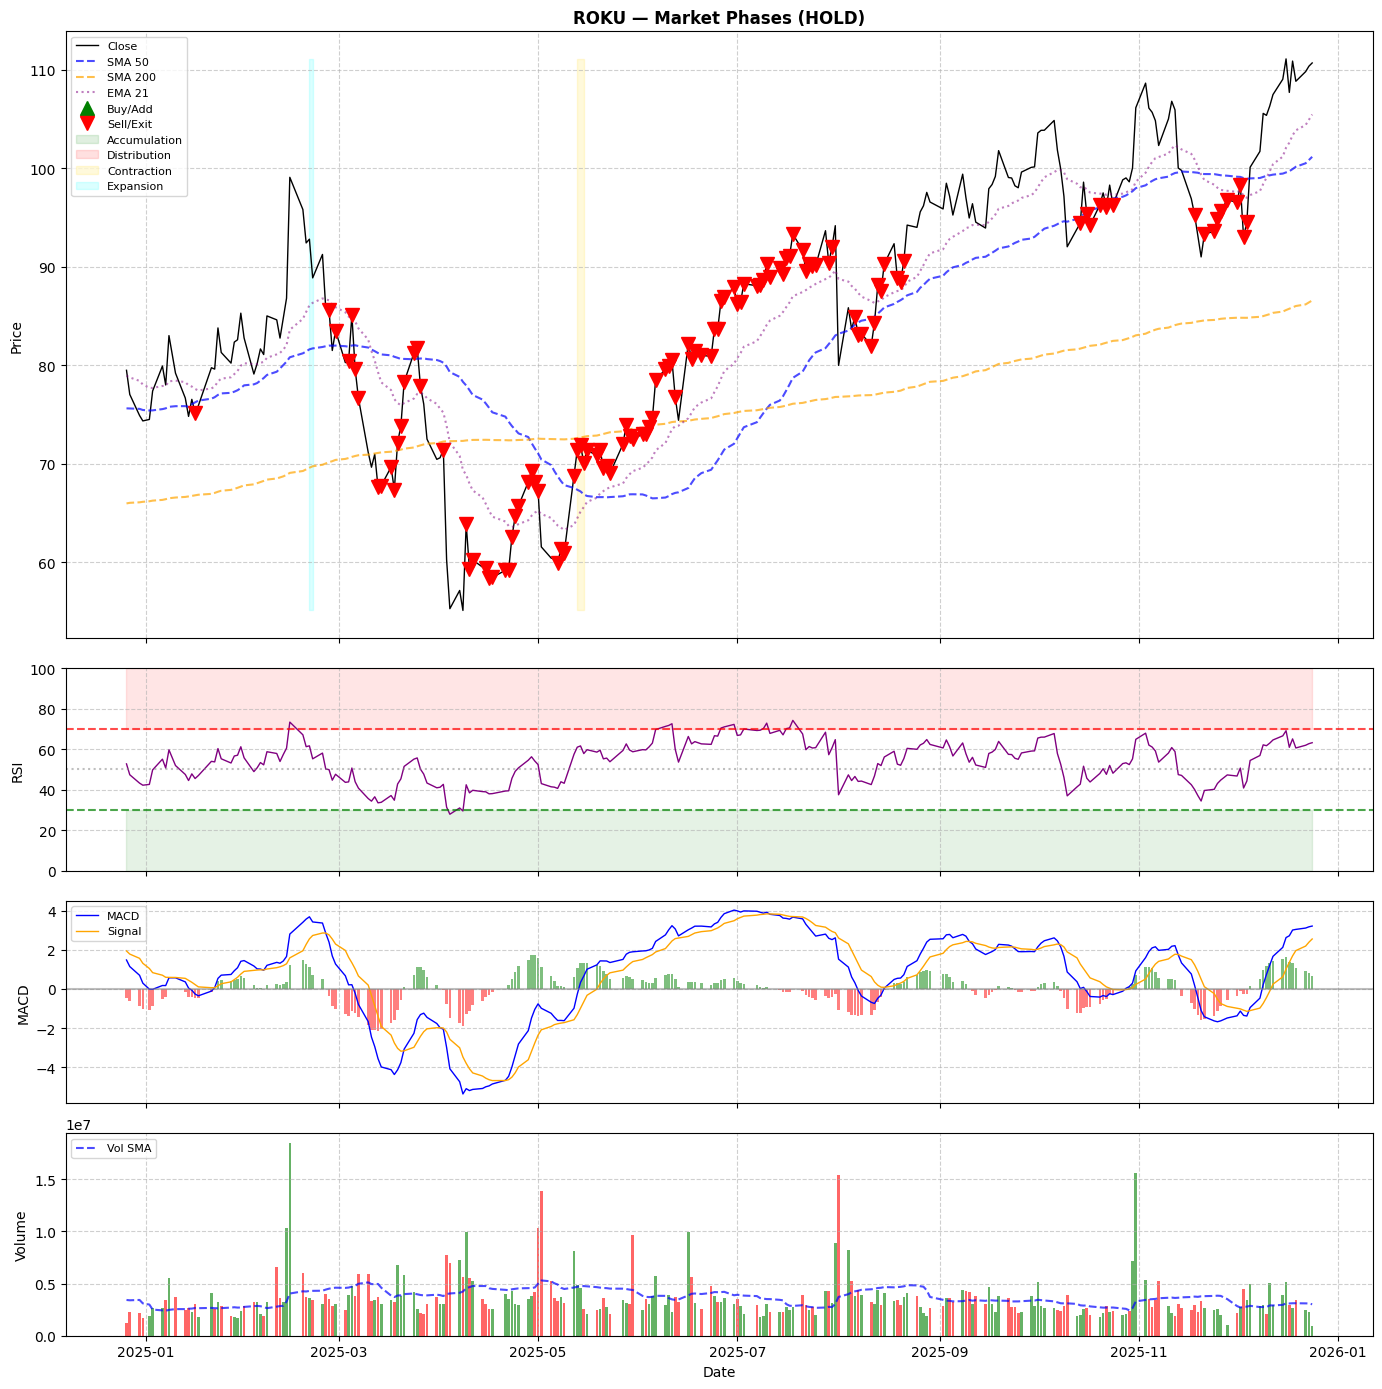

In [23]:
# ----------------------------
# PARAMETERS (Edit These)
# ----------------------------

# ----------------------------
# RUN THE FUNCTION
# ----------------------------
df = plot_technical_indicators("ROKU", years=2, start_date="2024-01-01")


In [ ]:
# dravas pattern code
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ==================== Functions ====================

def download_data(ticker: str, period: str = "2y", interval: str = "1d", auto_adjust=True):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=auto_adjust)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.dropna(inplace=True)
    return df

def build_darvas_boxes_vectorized(df: pd.DataFrame, window: int = 4):
    df = df.copy()
    df['Box_Top'] = np.nan
    df['Box_Bottom'] = np.nan

    # Detect rising highs sequence
    rising_highs = (df['High'].shift(window-1) < df['High'].shift(window-2)) & \
                   (df['High'].shift(window-2) < df['High'].shift(window-3)) & \
                   (df['High'].shift(window-3) < df['High'])

    df.loc[rising_highs, 'Box_Top'] = df['High']

    # Box Bottom: rolling min and forward-fill
    df['Box_Bottom'] = df['Low'].rolling(window=window, min_periods=1).min().ffill()

    # Forward-fill Box Top to extend box visually
    df['Box_Top'] = df['Box_Top'].ffill()
    return df

def darvas_signals_trailing(df: pd.DataFrame, sell_pct: float = 0.03):
    """
    Generate buy/sell signals:
    - Buy: Close > Box_Top
    - Sell: Close drops more than `sell_pct` from highest Box_Top so far (Darvas-style trailing stop)
    """
    df = df.copy()
    df['Signal'] = 0
    df['Highest_Top'] = df['Box_Top'].cummax()  # track highest box top

    # Buy signal
    df.loc[df['Close'] > df['Box_Top'], 'Signal'] = 1

    # Sell signal: price drops below highest Box_Top * (1 - sell_pct)
    df.loc[df['Close'] < df['Highest_Top'] * (1 - sell_pct), 'Signal'] = -1

    return df

def plot_darvas(df: pd.DataFrame, ticker: str):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df["Close"], mode="lines", name="Close", line=dict(color="black")))
    fig.add_trace(go.Scatter(x=df.index, y=df["Box_Top"], mode="lines", name="Box Top", line=dict(color="green", dash="dash")))
    fig.add_trace(go.Scatter(x=df.index, y=df["Box_Bottom"], mode="lines", name="Box Bottom", line=dict(color="red", dash="dash")))

    buys = df[df["Signal"] == 1]
    sells = df[df["Signal"] == -1]

    fig.add_trace(go.Scatter(x=buys.index, y=buys["Close"], mode="markers",
                             marker=dict(symbol="triangle-up", color="green", size=12), name="Buy"))
    fig.add_trace(go.Scatter(x=sells.index, y=sells["Close"], mode="markers",
                             marker=dict(symbol="triangle-down", color="red", size=12), name="Sell"))

    fig.update_layout(title=f"Interactive Darvas Box — {ticker}",
                      xaxis_title="Date", yaxis_title="Price",
                      template="plotly_white", hovermode="x unified")
    fig.show()




In [ ]:
# dravas pattern for a stock
# ==================== Variables ====================
ticker = "ROKU"
period = "6mo"
interval = "1d"
window = 4
sell_pct = 0.03  # 3% trailing stop from highest Box_Top

# ==================== Execution ====================
df = download_data(ticker=ticker, period=period, interval=interval)
df = build_darvas_boxes_vectorized(df, window=window)
df = darvas_signals_trailing(df, sell_pct=sell_pct)
plot_darvas(df, ticker=ticker)

[*********************100%***********************]  1 of 1 completed


back testing and profit calculator

[*********************100%***********************]  1 of 1 completed


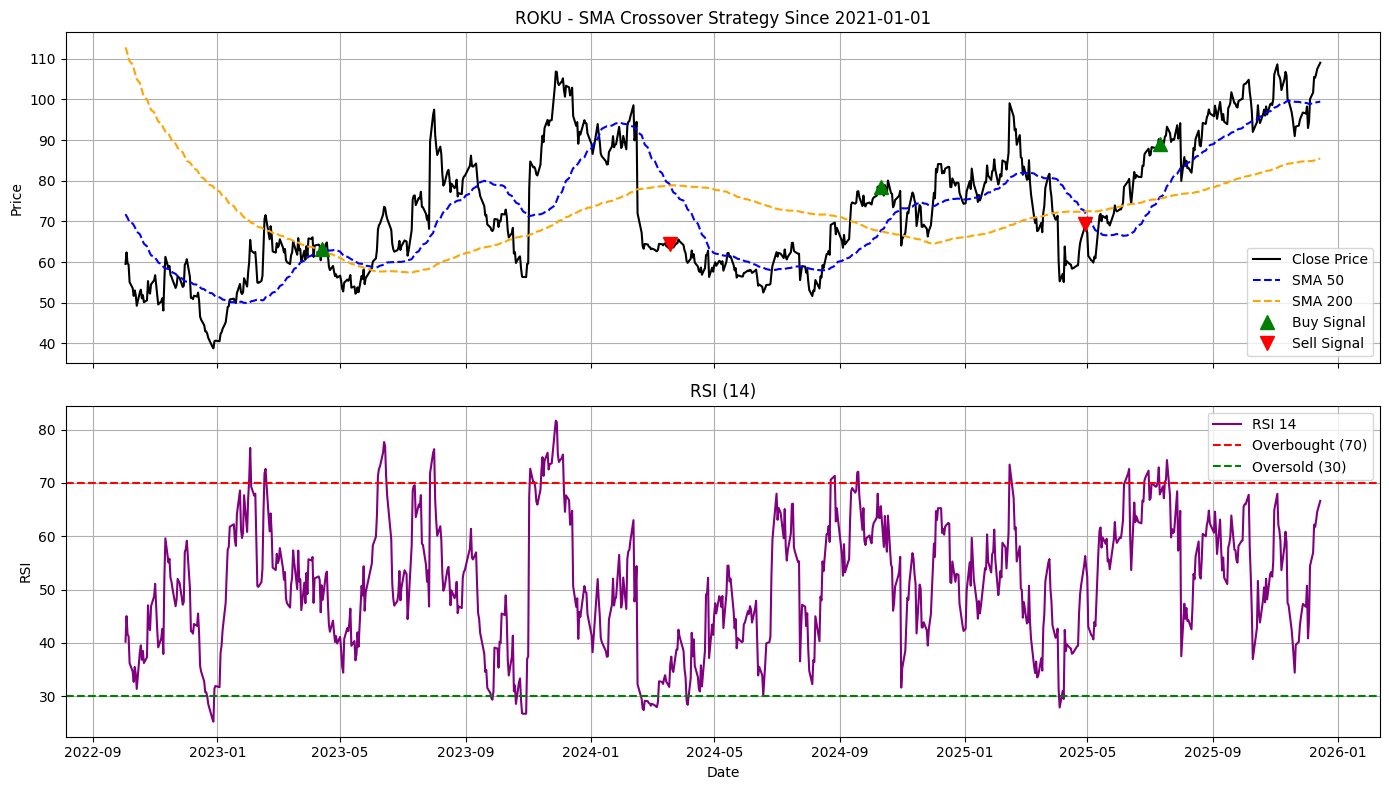


Final Portfolio Value: $11,039.03
Total Return: 10.39%

Trade History:
            Action      Price  Portfolio Value
Date                                         
2023-04-13    BUY  63.320000     10000.000000
2024-03-19   SELL  64.540001     10192.672335
2024-10-11    BUY  78.370003     10192.672335
2025-04-29   SELL  69.279999      9010.441523
2025-07-11    BUY  88.989998      9010.441523


In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def plot_and_backtest_sma_rsi_strategy(ticker: str, years: int, start_date: str, initial_cash: float = 10000):
    data = yf.download(ticker, period=f"{years}y", interval="1d", auto_adjust=True)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    df = data[['Close']].copy()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI_14'] = ta.rsi(df['Close'], length=14)

    df = df[df.index >= start_date]
    df.dropna(inplace=True)

    df['Signal'] = 0
    df.loc[(df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1)), 'Signal'] = 1
    df.loc[(df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1)), 'Signal'] = -1

    position = 0
    cash = initial_cash
    portfolio = initial_cash
    trade_log = []

    for date, row in df.iterrows():
        price = row['Close']
        signal = row['Signal']
        if signal == 1 and cash > 0:
            position = cash / price
            cash = 0
            trade_log.append((date, 'BUY', price, portfolio))
        elif signal == -1 and position > 0:
            cash = position * price
            position = 0
            trade_log.append((date, 'SELL', price, cash))
            portfolio = cash

    if position > 0:
        portfolio = position * df['Close'].iloc[-1]

    buys = df[df['Signal'] == 1]
    sells = df[df['Signal'] == -1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    ax1.plot(df.index, df['Close'], label='Close Price', color='black')
    ax1.plot(df.index, df['SMA_50'], label='SMA 50', color='blue', linestyle='--')
    ax1.plot(df.index, df['SMA_200'], label='SMA 200', color='orange', linestyle='--')
    ax1.plot(buys.index, buys['Close'], '^', color='green', label='Buy Signal', markersize=10)
    ax1.plot(sells.index, sells['Close'], 'v', color='red', label='Sell Signal', markersize=10)
    ax1.set_title(f"{ticker} - SMA Crossover Strategy Since {start_date}")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(df.index, df['RSI_14'], label='RSI 14', color='purple')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.set_title("RSI (14)")
    ax2.set_ylabel("RSI")
    ax2.set_xlabel("Date")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    trades = pd.DataFrame(trade_log, columns=['Date', 'Action', 'Price', 'Portfolio Value'])
    trades.set_index('Date', inplace=True)

    print(f"\nFinal Portfolio Value: ${portfolio:,.2f}")
    print(f"Total Return: {((portfolio - initial_cash) / initial_cash) * 100:.2f}%")
    print("\nTrade History:\n", trades)

# Example:
plot_and_backtest_sma_rsi_strategy("ROKU", years=4, start_date="2021-01-01")

get data to find stocks

In [ ]:
import yfinance as yf
import pandas as pd

# Define tickers (can be expanded)
tickers = [
    "ALLY", "AXP", "BAC", "CFG", "CMC", "CRDO", "CSX", "DDOG", "ELAN",
    "EW", "GILD", "GM", "ISRG", "JEF", "LBRT", "LEN", "LTH", "MWA",
    "OWL", "PLD", "PNFP", "PRM", "SNPS", "SYF", "TSLA", "TTD", "WAL"
]

def check_buy_conditions(ticker):
    try:
        df = yf.download(ticker, period="6mo", interval="1d", auto_adjust=True, progress=False)
        if df.empty or len(df) < 200:
            return None

        df["SMA_50"] = df["Close"].rolling(window=50).mean()
        df["SMA_200"] = df["Close"].rolling(window=200).mean()

        # Calculate RSI
        delta = df["Close"].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df["RSI_14"] = 100 - (100 / (1 + rs))

        df.dropna(inplace=True)
        if df.empty:
            return None

        latest = df.iloc[-1]

        if (
            latest["Close"] > latest["SMA_50"]
            and latest["Close"] > latest["SMA_200"]
            and latest["SMA_50"] > latest["SMA_200"]
            and 45 <= latest["RSI_14"] <= 60
        ):
            return {
                "Ticker": ticker,
                "Close": round(latest["Close"], 2),
                "SMA_50": round(latest["SMA_50"], 2),
                "SMA_200": round(latest["SMA_200"], 2),
                "RSI_14": round(latest["RSI_14"], 2),
            }
    except Exception as e:
        print(f"⚠️ Error with {ticker}: {e}")
        return None

# Run scan
results = [check_buy_conditions(t) for t in tickers]
filtered = [r for r in results if r is not None]

# Show results
if filtered:
    df = pd.DataFrame(filtered)
    df = df.sort_values("RSI_14", ascending=False).reset_index(drop=True)
    print(df)
else:
    print("❌ No stocks matched the filter conditions.")



❌ No stocks matched the filter conditions.
